# Notebook for basic models testing

In [1]:
%matplotlib inline

## Dataset loading
So far, a single source dataset is used

In [2]:
#% Imports
import pandas as pd

#% Data import
#% engine=python because C engine has an error with a character in the middle of
## the file. May be slower but works.

df = pd.read_csv('../Datasets/macdonalds_for_guillaume.csv', engine='python')

## Dataset structure

This work has been moved to the file [dataset.py](dataset.py)

In [3]:
from dataset import Dataset

Using TensorFlow backend.


## Utility functions
* examine_cv gives a quick overview of a cross validation result
* filter_text filters characters from a text

This work has been moved to [utils_npi.py](utils_npi.py)

In [4]:
from npi_utils import examine_cv, filter_text, remove_double

## Models


These classes are used to handle different kind of models seamlessly  
This has been moved to the [models.py](models.py) file

In [5]:
import models

## Adding models
Models added :
* A naive Bayes model
* A linear SVM
* A RBF kernel SVM
* A polynomial kernel SVM
* GRU with 1 layer
* GRU with 2 layer
* LSTM with 1 layer
* LSTM with 2 layer
* Bi-directional GRU with 1 layer
* Bi-directional GRU with 2 layers
* Bi-directional LSTM with 1 layer
* Bi-directional LSTM with 2 layers -> With several epochs
* Random forest

In [6]:
models_list = []
models_list.append(models.NaiveBayesModelHandler())
models_list.append(models.LinearSVCModelHandler())

#% These models are slow, and not really good
#models.append(PolySVCModelHandler())
#models.append(RBFSVCModelHandler())

models_list.append(models.GRU1ModelHandler())
models_list.append(models.GRU2ModelHandler())
models_list.append(models.LSTM1ModelHandler())
models_list.append(models.LSTM2ModelHandler())
models_list.append(models.BiDirGRU1ModelHandler())
models_list.append(models.BiDirGRU2ModelHandler())
models_list.append(models.BiDirLSTM1ModelHandler())
models_list.append(models.BiDirLSTM2ModelHandler())

models_list.append(models.RandomForestModelHandler())

## Adding datasets
First we add the basic texts set.  
Stemming may help some models. So we will create an additional dataset with the stemmed texts

In [7]:
from nltk import SnowballStemmer

#% Datasets
datasets = []

#% Basic texts
texts = df['text']
y = df['neg_pi'].values

#% Stem words
stemmer = SnowballStemmer("english")

stemmed_texts = [' '.join([stemmer.stem(w) for w in filter_text(t).split()]) for t in texts]
consonnant_code_texts = [remove_double(filter_text(t, filtered="aeiouy")) for t in stemmed_texts]

print('mcdonalds')
datasets.append(Dataset(texts, y, 'mcdonalds'))

print('stemmed mcdonalds')
datasets.append(Dataset(stemmed_texts, y, 'stemmed mcdonalds'))
"""
print('balanced mcdonalds')
datasets.append(Dataset(texts, y, 'balanced mcdonalds', is_balanced = True))

print('balanced stemmed mcdonalds')
datasets.append(Dataset(stemmed_texts, y, 'balanced stemmed mcdonalds', is_balanced = True))

for dataset in datasets:
    print(dataset.name, ', vocabulary size :', dataset.vocabulary_size)"""


mcdonalds
stemmed mcdonalds


"\nprint('balanced mcdonalds')\ndatasets.append(Dataset(texts, y, 'balanced mcdonalds', is_balanced = True))\n\nprint('balanced stemmed mcdonalds')\ndatasets.append(Dataset(stemmed_texts, y, 'balanced stemmed mcdonalds', is_balanced = True))\n\nfor dataset in datasets:\n    print(dataset.name, ', vocabulary size :', dataset.vocabulary_size)"

## Start the analysis

-----
Sklearn Naive Bayes
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Sklearn Linear SVC
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 300 embedding GRU 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 300 embedding GRU 2 layers 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 300 embedding LSTM 1 layer 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 300 embedding LSTM 2 layers 64 cells
Dataset mcdonalds
This has been done already.
Dataset stemmed mcdonalds
This has been done already.
-----
-----
Keras 50 epochs 300 embedding Bi Directional GRU 1 layer 64 cells
Dataset m

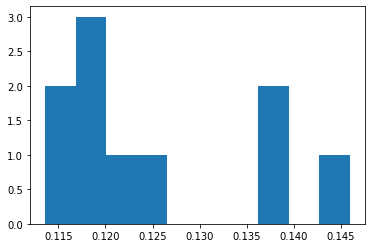

Accuracy scores
Values: 0.9555 (+/- 0.0024)


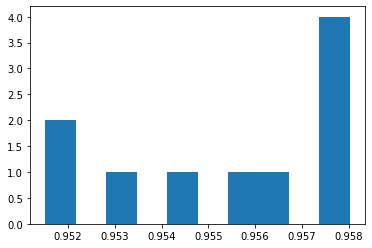

f1 scores
Values: 0.5299 (+/- 0.0314)


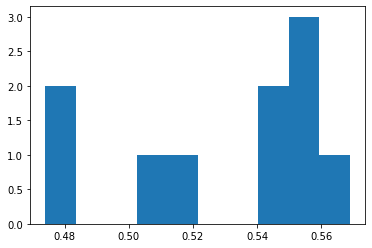

roc scores
Values: 0.9573 (+/- 0.0066)


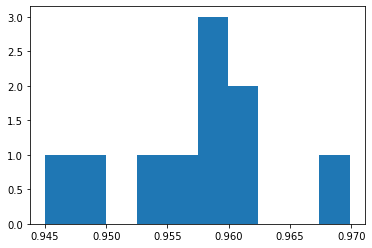

Done.
Dataset stemmed mcdonalds
Done, time spent 265328.4857273102 ms
log loss
Values: 0.1262 (+/- 0.0087)


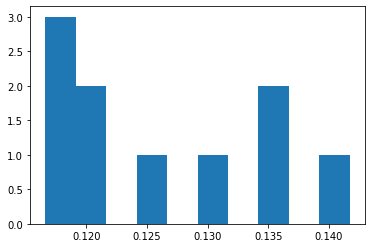

Accuracy scores
Values: 0.9558 (+/- 0.0017)


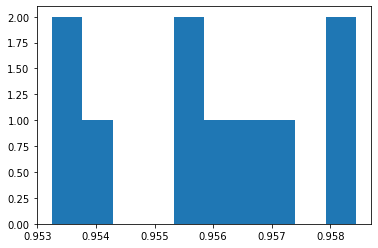

f1 scores
Values: 0.5293 (+/- 0.0227)


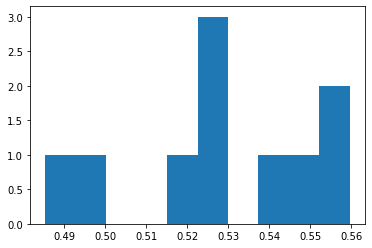

roc scores
Values: 0.9587 (+/- 0.0047)


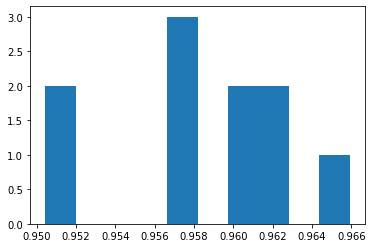

Done.
-----


In [8]:
import time
from os import path
import os

#% Result file
result_file = 'result.csv'

#% Clear the result file
clear_file = False

#% Models/Datasets done
models_dataset_done = []

if path.exists(result_file) and not clear_file:
    result_content = pd.read_csv(result_file, engine='python')
    models_dataset_done = [(e[0], e[1]) for e in result_content[['model','dataset']].values]
else:
    clear_file = True

if clear_file:
    f = open(result_file, "w")
    f.write('model,dataset,accuracies,mean_acc,std_acc,f1_scores,mean_f1,std_f1,log_loss,mean_log_loss,std_log_loss,roc_auc_scores,mean_roc_auc,std_roc_auc,ms_time\n')
    f.close()
    
#% Analyze every model on every dataset
for model in models_list:
    model_name = ' '.join(model.get_info())
    print('-----')
    print(model_name)

    for dataset in datasets:
        print('Dataset', dataset.name)
        
        #% Check if it has already been done
        if (model_name, dataset.name) in models_dataset_done:
            print('This has been done already.')
            continue

        #% Time the cross validation to have an idea on how long it takes to fit
        time1 = time.time()

        #% We used 10 folds cross validation
        cv_accuracies, cv_f1s, cv_logloss, cv_rocaucs = model.cross_validate(dataset, 10)

        time2 = time.time()
        #% Elapsed time in ms
        ms_time = (time2 - time1) * 1000.0

        print('Done, time spent', ms_time, 'ms')

        #% Display a summary of the model perfs
        print('log loss')
        mean_logloss, std_logloss = examine_cv(cv_logloss)
        print('Accuracy scores')
        mean_acc, std_acc = examine_cv(cv_accuracies)
        print('f1 scores')
        mean_f1, std_f1 = examine_cv(cv_f1s)
        print('roc scores')
        mean_roc, std_roc = examine_cv(cv_rocaucs)

        #% Add entry to result file
        file_entry = []
        file_entry.append(model_name)
        file_entry.append(dataset.name)
        file_entry.append(';'.join([str(s) for s in sorted(cv_accuracies)]))
        file_entry.append(str(mean_acc))
        file_entry.append(str(std_acc))
        file_entry.append(';'.join([str(s) for s in sorted(cv_f1s)]))
        file_entry.append(str(mean_f1))
        file_entry.append(str(std_f1))
        file_entry.append(';'.join([str(s) for s in sorted(cv_logloss)]))
        file_entry.append(str(mean_logloss))
        file_entry.append(str(std_logloss))
        file_entry.append(';'.join([str(s) for s in sorted(cv_rocaucs)]))
        file_entry.append(str(mean_roc))
        file_entry.append(str(std_roc))
        file_entry.append(str(ms_time))
        
        f = open(result_file, "a")
        f.write(','.join(file_entry) + '\n')
        f.close()
        print('Done.')
    print('-----')